In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap


In [216]:
# Step 1: Load Excel Dataset
file_path = 'financialdata.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

In [218]:
# Step 2: Data Preprocessing
# Drop rows with missing target 'profitMargins'
df = df.dropna(subset=['profitMargins'])

# Select numeric features relevant for modeling
feature_cols = [
    'ebitdaMargins', 'grossMargins', 'operatingCashflow', 'revenueGrowth',
    'operatingMargins', 'ebitda', 'grossProfits', 'freeCashflow',
    'currentRatio', 'returnOnAssets', 'debtToEquity', 'returnOnEquity',
    'totalCash', 'totalDebt', 'totalRevenue', 'quickRatio', 'pegRatio',
    'forwardPE', 'marketCap'
]
feature_cols = [col for col in feature_cols if col in df.columns]

# Drop rows with missing values in features
df = df.dropna(subset=feature_cols)

In [220]:
# Step 3: Clustering companies based on financial features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

print("Cluster counts:\n", df['cluster'].value_counts())


Cluster counts:
 cluster
4    98
0    79
1    14
2     6
3     1
Name: count, dtype: int64


In [222]:
# Step 4: Prepare features and target
X = df[feature_cols]
y = df['profitMargins']


In [224]:
# Step 5: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [226]:
# Step 6: Define models and hyperparameter grids
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LinearRegression': LinearRegression()
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    },
    'LinearRegression': {}  # No hyperparameters
}

best_models = {}
for name, model in models.items():
    print(f"\nTraining and tuning {name}...")
    if param_grids[name]:
        grid = GridSearchCV(model, param_grids[name], cv=3, scoring='r2', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        print(f"Best parameters for {name}: {grid.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[name] = model



Training and tuning RandomForest...
Best parameters for RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Training and tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Training and tuning LinearRegression...


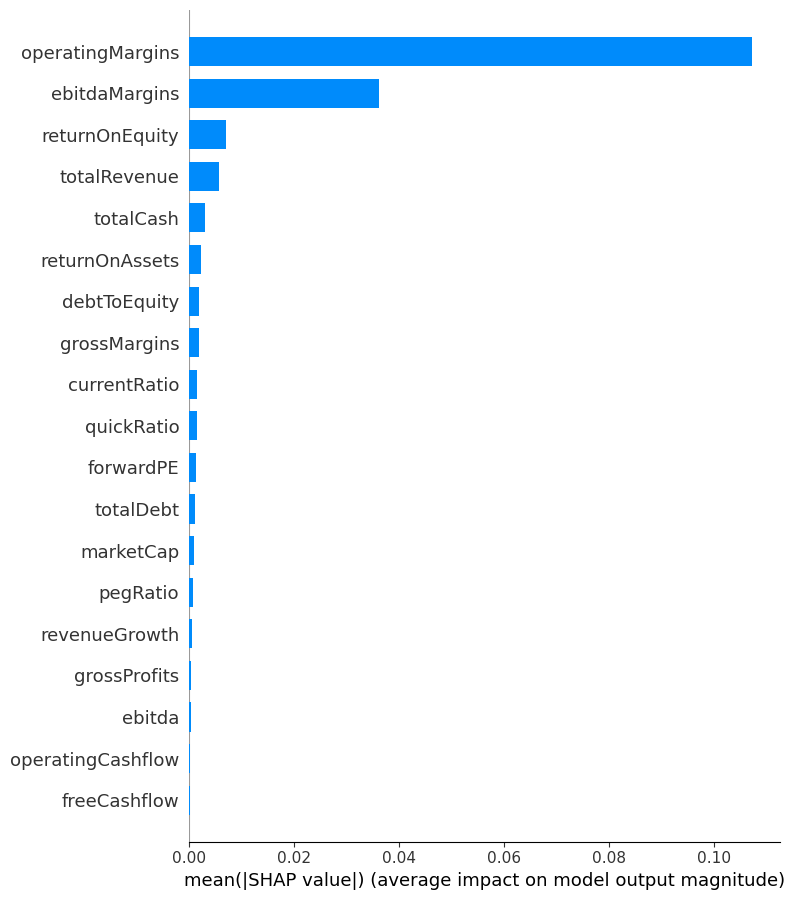

In [228]:
# Step 8: Explain best model predictions with SHAP (using Random Forest here)
best_model = best_models['RandomForest']

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")



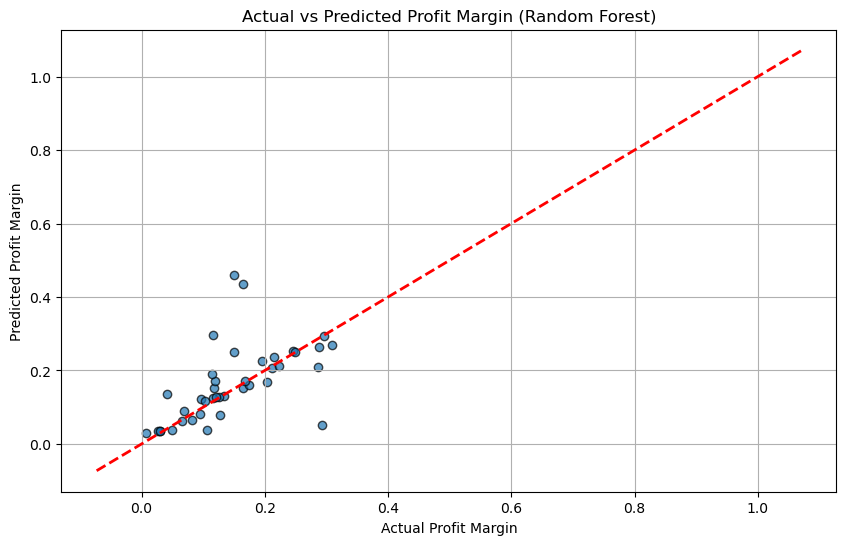

In [230]:
# Step 9: Visualize Actual vs Predicted for best model
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Profit Margin')
plt.ylabel('Predicted Profit Margin')
plt.title('Actual vs Predicted Profit Margin (Random Forest)')
plt.grid(True)
plt.show()
